In [6]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

a = 1
b = 2
k_r = 1.5
k_i = 1
v_1 = 1
v_2 = 1
v_3 = 1
c = np.log((a * a * v_1 + b * b * v_2 + a * b * v_3 + a * b * v_3) / ((2 * k_r) * (2 * k_r)))
print(sys.executable)
#周期性边界条件
x_lower = -10
x_upper = 10
t_lower = -2
t_upper =2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    r1=2
    r2=4
    r3=-2
    r4=0
    beta=1
    
    f_u1 = (
            v1_t + u1_xx
        + r1*u1*(u1**2 + v1**2) + r2*u1*(u2**2 + v2**2) + r3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + r4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

    f_v1 = (
            -u1_t + v1_xx
        + r1*v1*(u1**2 + v1**2) + r2*v1*(u2**2 + v2**2) - r3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - r4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
    )

    f_u2 = (
            v2_t + beta*u1_xx
        + r1*u2*(u2**2 + v2**2) + r2*u2*(u1**2 + v1**2) + r3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + r4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
    )

    f_v2 = (
            -u2_t + beta*v2_xx
        + r1*v2*(u2**2 + v2**2) + r2*v2*(u1**2 + v1**2) - r3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - r4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
    )
    
    return [
        f_u1, f_v1, f_u2, f_v2,
        #f_u1x, f_u1t,
        #f_v1x, f_v1t,
        #f_u2x, f_u2t,
        #f_v2x, f_v2t
    ]
 # 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
#(e^c=...)
# 初始条件
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

m0=1 #a
m1=np.sqrt(1) #b
m2=0 #Δ
m3=0 #θ





#lambda
c11=1
c21=2
c31=-2
c41=4
lambda1=1

v1=(c31.conjugate()**2+c41.conjugate()**2)*(c11*c31+c21*c41)
v2=(c11**2+c21**2)*(c11.conjugate()**2+c21.conjugate()**2)
v3=(c31.conjugate()**2+c41.conjugate()**2)*(c21*c31-c11*c41)

eta1=np.log((c11**2+c21**2)*(c11.conjugate()*c31.conjugate()+c21.conjugate()*c41.conjugate())/v1)/2
eta2=np.log(v2/((c11*c11.conjugate()+c21*c21.conjugate())*(c31*c31.conjugate()+c41*c41.conjugate())))/2
eta3=np.log((c11**2+c21**2)*(c21*c31-c11*c41)/v3)/2
gamma1=(c31**2+c41**2)*(c31.conjugate()**2+c41.conjugate()**2)

def init_cond_u1(x):
    xi1=-2*1j*lambda1**2*x[:,1:2]-1j*lambda1*x[:,0:1]
    q1=4*v1*1j*(lambda1.conjugate()-lambda1)*np.exp(3*xi1+xi1.conjugate()+eta1)*np.cosh(xi1+xi1.conjugate()+eta1)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
    q2=4*v3*1j*(lambda1-lambda1.conjugate())*np.exp(3*xi1+xi1.conjugate()+eta3)*np.cosh(xi1+xi1.conjugate()+eta3)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
    return q1.real
    
def init_cond_u2(x):
    "2 tanh(x)"
    xi1=-2*1j*lambda1**2*x[:,1:2]-1j*lambda1*x[:,0:1]
    q1=4*v1*1j*(lambda1.conjugate()-lambda1)*np.exp(3*xi1+xi1.conjugate()+eta1)*np.cosh(xi1+xi1.conjugate()+eta1)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
    q2=4*v3*1j*(lambda1-lambda1.conjugate())*np.exp(3*xi1+xi1.conjugate()+eta3)*np.cosh(xi1+xi1.conjugate()+eta3)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
    return q2.real

def init_cond_v1(x):
    xi1=-2*1j*lambda1**2*x[:,1:2]-1j*lambda1*x[:,0:1]
    q1=4*v1*1j*(lambda1.conjugate()-lambda1)*np.exp(3*xi1+xi1.conjugate()+eta1)*np.cosh(xi1+xi1.conjugate()+eta1)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
    q2=4*v3*1j*(lambda1-lambda1.conjugate())*np.exp(3*xi1+xi1.conjugate()+eta3)*np.cosh(xi1+xi1.conjugate()+eta3)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
    return -q1.imag

def init_cond_v2(x):
    xi1=-2*1j*lambda1**2*x[:,1:2]-1j*lambda1*x[:,0:1]
    q1=4*v1*1j*(lambda1.conjugate()-lambda1)*np.exp(3*xi1+xi1.conjugate()+eta1)*np.cosh(xi1+xi1.conjugate()+eta1)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
    q2=4*v3*1j*(lambda1-lambda1.conjugate())*np.exp(3*xi1+xi1.conjugate()+eta3)*np.cosh(xi1+xi1.conjugate()+eta3)/(2*v2*np.exp(3*(xi1+xi1.conjugate())+eta2)*np.cosh(xi1+xi1.conjugate()+eta2)+gamma1)
    return -q2.imag

ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 5 + [4], "silu", "Glorot normal")

model = dde.Model(data, net)

d:\anaconda\python.exe
d:\anaconda\python.exe


In [7]:
model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=3000, display_every=10)

Compiling model...
Building feed-forward neural network...
'build' took 0.120900 s



C:\Users\86183\AppData\Roaming\Python\Python39\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 7.826585 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [1.03e-04, 4.96e-05, 4.82e-05, 1.15e-04, 2.05e-02, 9.73e-04, 2.68e-03, 7.77e-04, 2.58e-02, 2.85e-05, 1.33e-03, 2.78e-04, 1.37e-02, 5.64e-01, 2.04e-02, 9.81e-01]    [1.03e-04, 4.96e-05, 4.82e-05, 1.15e-04, 2.05e-02, 9.73e-04, 2.68e-03, 7.77e-04, 2.58e-02, 2.85e-05, 1.33e-03, 2.78e-04, 1.37e-02, 5.64e-01, 2.04e-02, 9.81e-01]    []  
10        [2.43e-03, 7.50e-05, 7.55e-03, 1.98e-04, 9.32e-05, 2.07e-04, 3.33e-04, 7.44e-04, 4.67e-04, 1.58e-05, 4.40e-04, 2.32e-03, 8.53e-03, 4.95e-01, 1.66e-02, 8.54e-01]    [2.43e-03, 7.50e-05, 7.55e-03, 1.98e-04, 9.32e-05, 2.07e-04, 

(<deepxde.model.LossHistory at 0x1e832569b80>,
 <deepxde.model.TrainState at 0x1e849145550>)

Compiling model...
'compile' took 4.880333 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
3000      [6.54e-03, 3.86e-02, 1.01e-02, 5.63e-02, 9.05e-03, 7.89e-04, 3.05e-03, 3.65e-05, 1.91e-03, 2.18e-03, 2.34e-04, 2.53e-04, 9.45e-03, 3.08e-01, 9.31e-03, 5.58e-01]    [6.54e-03, 3.86e-02, 1.01e-02, 5.63e-02, 9.05e-03, 7.89e-04, 3.05e-03, 3.65e-05, 1.91e-03, 2.18e-03, 2.34e-04, 2.53e-04, 9.45e-03, 3.08e-01, 9.31e-03, 5.58e-01]    []  
4000      [3.31e-02, 2.84e-02, 2.18e-02, 3.35e-02, 2.66e-04, 1.81e-04, 3.61e-04, 1.22e-05, 8.10e-05, 1.67e-05, 9.27e-05, 2.03e-05, 1.74e-03, 1.22e-02, 4.72e-03, 2.71e-02]                                                                        

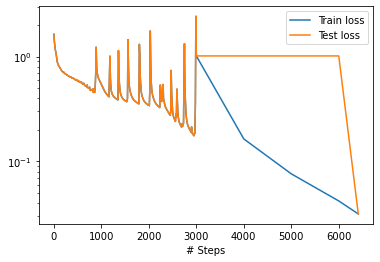

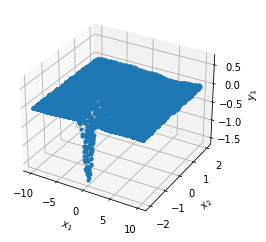

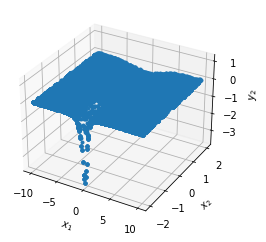

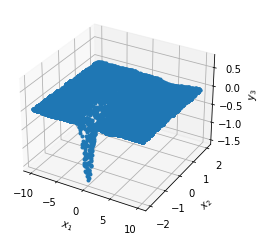

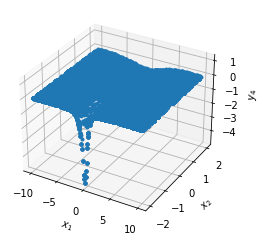

In [8]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=3000,
    maxfun=5000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()


dde.saveplot(losshistory, train_state, issave=True, isplot=True)

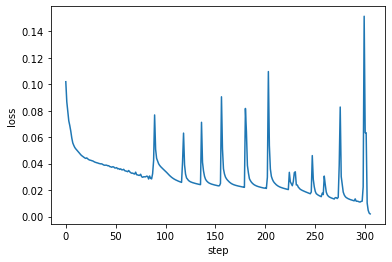

In [9]:

loss_t = losshistory.loss_train



plt.plot(np.mean(loss_t,axis=1))
plt.xlabel("step")
plt.ylabel("loss")

print(losshistory)
print(train_state)

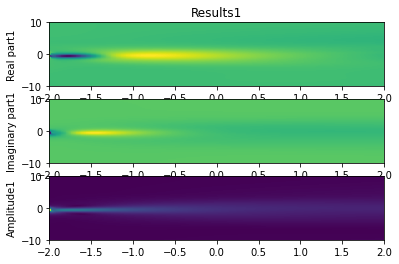

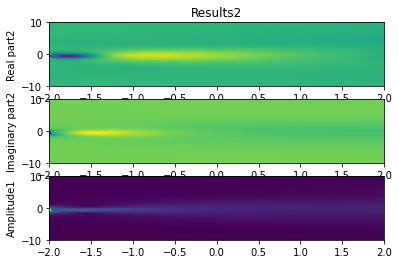

In [10]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()

[ 533940  529232  524597 ... 2286520 2270346 2254868]


ValueError: Argument Z must be 2-dimensional.

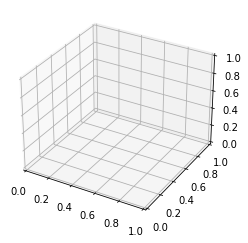

In [18]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:],cmap='plasma')


[ 56  54  52 ... 525 513 501]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


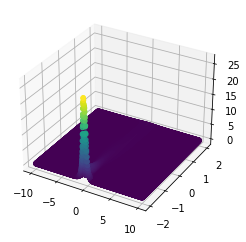

In [15]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:]/10)

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)

In [13]:
print(c)

3.0964216e-06
